#Senai Cimatec
#Disciplina: Visão computacional


##Discentes: Bruno Senna, Iuri Rodrigo, Vinicius e Luís
##Docente: Prabhat Kumar de Oliveira

# Importando bibliotecas e a base de dados

In [1]:
#Importando o fataset para o diretório do colab

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brunobisposenna","key":"7a9dba801ba1f1fc277dec47324eb56f"}'}

In [2]:
# Instalando a biblioteca Kaggle para baixar o dataset:

!pip install kaggle --upgrade

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Realizando o dowload do dataset:

!kaggle datasets download -d gpiosenka/balls-image-classification

 95% 188M/198M [00:06<00:00, 40.2MB/s]
100% 198M/198M [00:06<00:00, 34.1MB/s]


In [5]:
# Importando as bibliotecas necessárias:

from zipfile import ZipFile
from collections import Counter
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras
!pip install sweetviz
import sweetviz as sv

import tensorflow as tf
from tensorflow.keras.utils import plot_model,to_categorical
import keras.layers as kl
from keras.backend import clear_session
from keras import Sequential
from keras.layers import Conv2D,Dense,Dropout,Input,Flatten,MaxPooling2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import timeit
import numpy as np
from PIL import Image


     |████████████████████████████████| 15.1 MB 4.1 MB/s 


In [6]:
# Colocando a base de dados num arquivo zipado para ser guardado e suas imagens extraídas em formato jpg:

file_name = "balls-image-classification.zip"
  
# abrindo o arquivo zip em modo de leitura
with ZipFile(file_name, 'r') as zip:
     # imprimir todo o conteúdo do arquivo zip
    zip.printdir()
  
    # extraindo os arquivos 
    print('Extraindo...')
    zip.extractall()

A saída de streaming foi truncada nas últimas 5000 linhas.
balls _rev2/train/cricket ball/097.jpg         2021-07-04 20:45:04        19888
balls _rev2/train/cricket ball/098.jpg         2021-07-04 20:45:04        27429
balls _rev2/train/cricket ball/099.jpg         2021-07-04 20:45:04        20947
balls _rev2/train/cricket ball/100.jpg         2021-07-04 20:45:04        22835
balls _rev2/train/cricket ball/101.jpg         2021-07-04 20:45:04        18191
balls _rev2/train/cricket ball/102.jpg         2021-07-04 20:45:04        25304
balls _rev2/train/cricket ball/103.jpg         2021-07-04 20:45:04        27637
balls _rev2/train/cricket ball/104.jpg         2021-07-04 20:45:04        21936
balls _rev2/train/cricket ball/105.jpg         2021-07-04 20:45:04        15289
balls _rev2/train/cricket ball/106.jpg         2021-07-04 20:45:04        26134
balls _rev2/train/cricket ball/107.jpg         2021-07-04 20:45:04        27351
balls _rev2/train/cricket ball/108.jpg         2021-07-04 20:

# Análise exploratória de dados

In [7]:
#Importando o dataset
df = pd.read_csv("/content/balls/balls.csv")

In [8]:
#Head do dataset
df.head(10)

,filepaths,labels,data set
0,train/baseball/001.jpg,baseball,train
1,train/baseball/002.jpg,baseball,train
2,train/baseball/003.jpg,baseball,train
3,train/baseball/004.jpg,baseball,train
4,train/baseball/005.jpg,baseball,train
5,train/baseball/006.jpg,baseball,train
6,train/baseball/007.jpg,baseball,train
7,train/baseball/008.jpg,baseball,train
8,train/baseball/009.jpg,baseball,train
9,train/baseball/010.jpg,baseball,train


In [9]:
#informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  3100 non-null   object
 1   labels     3100 non-null   object
 2   data set   3100 non-null   object
dtypes: object(3)
memory usage: 72.8+ KB


In [10]:
#Mean do dataset
df.mean()

Series([], dtype: float64)

In [11]:
#Descrição do dataset
df.describe()

,filepaths,labels,data set
count,3100,3100,3100
unique,3100,24,3
top,train/cannon ball/034.jpg,cannon ball,train
freq,1,193,2860


In [12]:
#Vendo se o dataset possui colunas nulas
df.isnull().sum()

filepaths    0
labels       0
data set     0
dtype: int64

In [13]:
#Contando o numero de dados do dataset
df.count()

filepaths    3100
labels       3100
data set     3100
dtype: int64

In [14]:
#Imprimindo o total de imagens
print(f"Total de imagens = {len(df)}")

Total de imagens = 3100


In [15]:
#Criando variavel da analise grafica pela biblioteca sweetviz
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


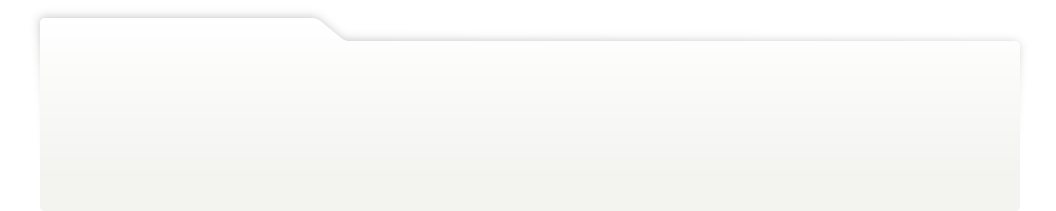
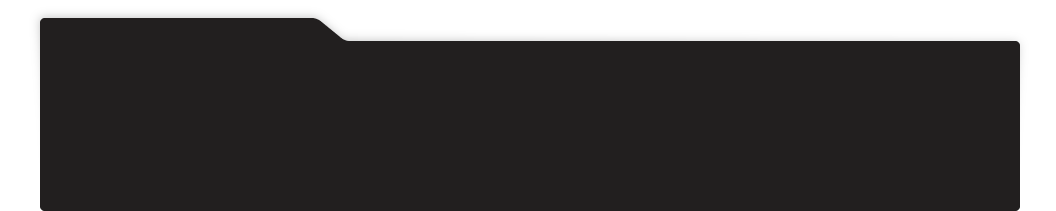
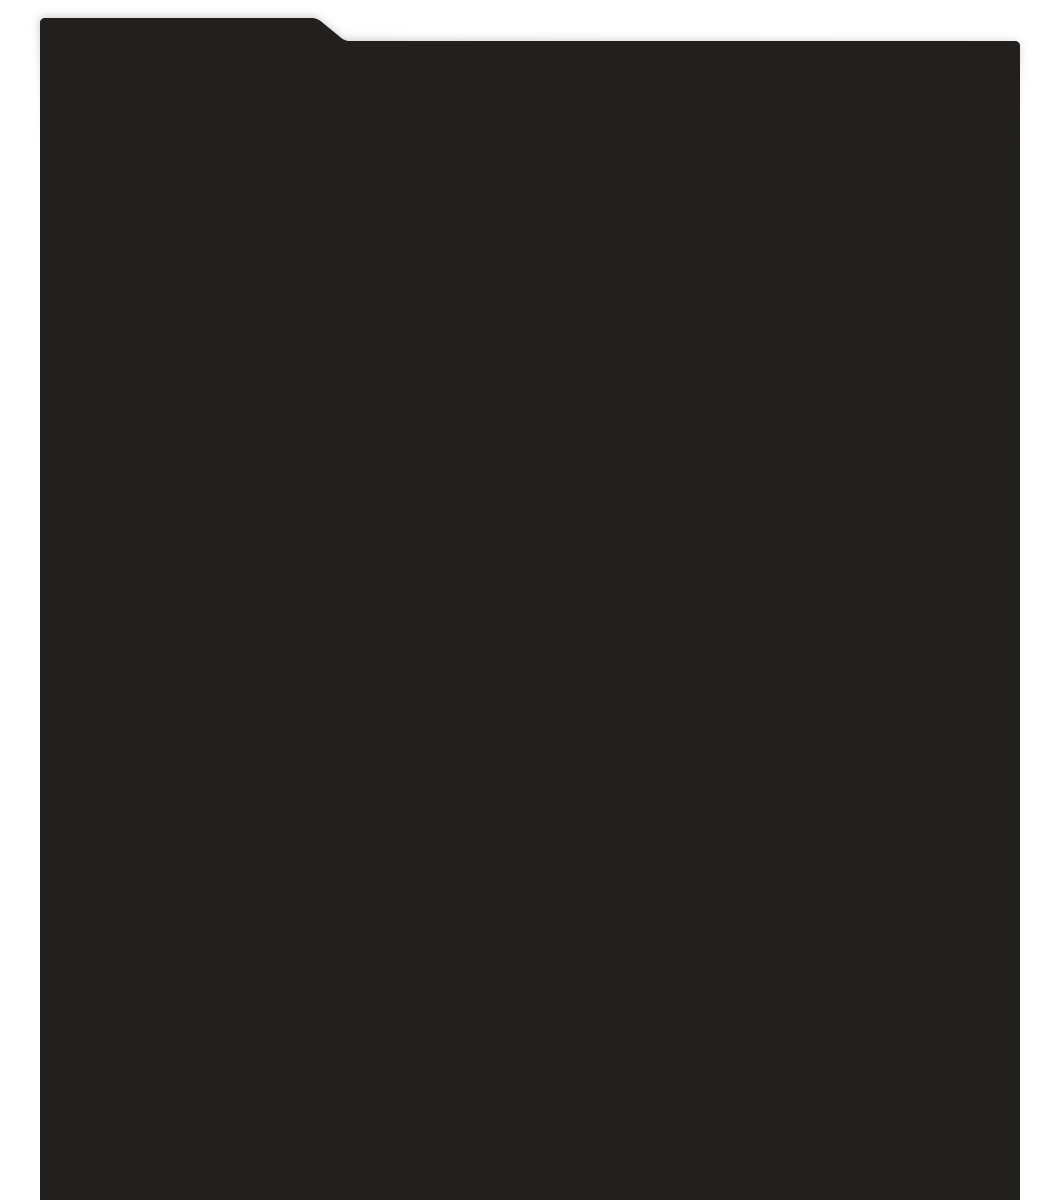
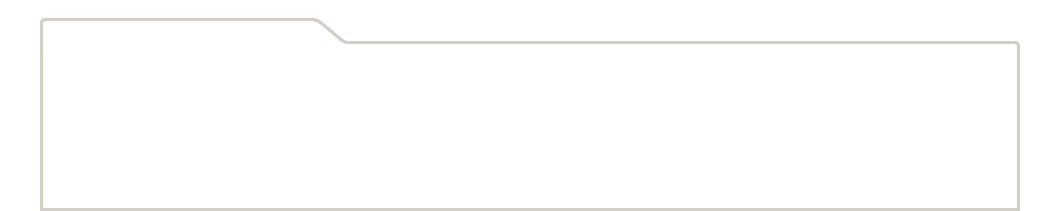
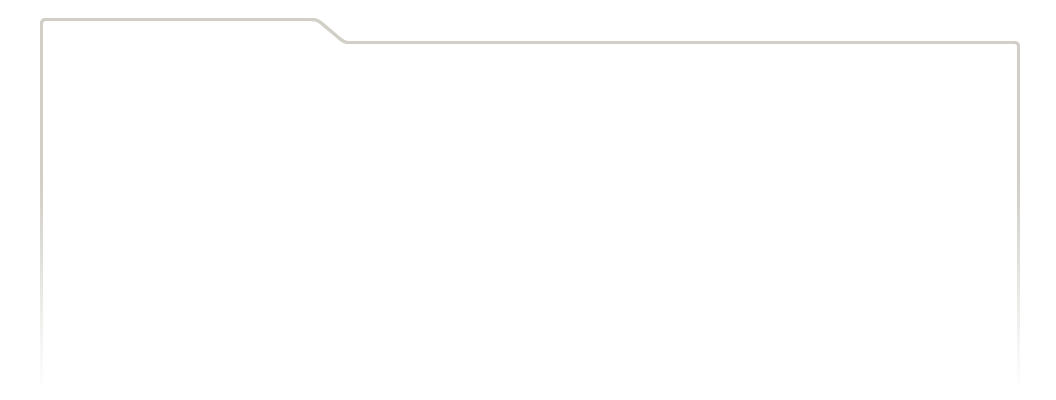
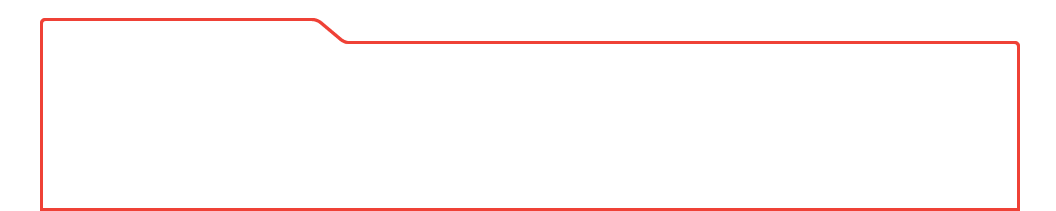
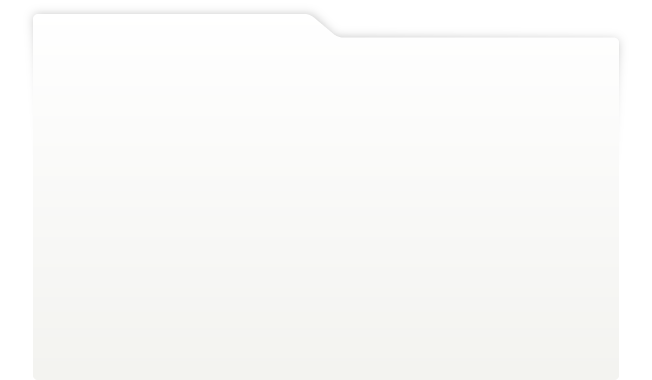
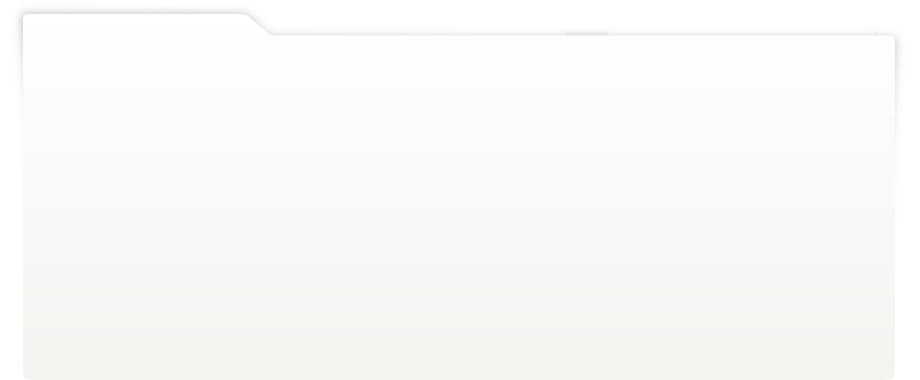
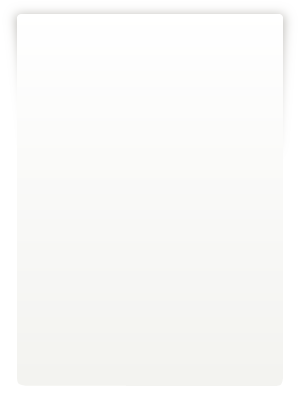
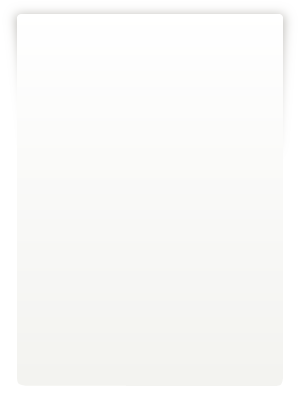
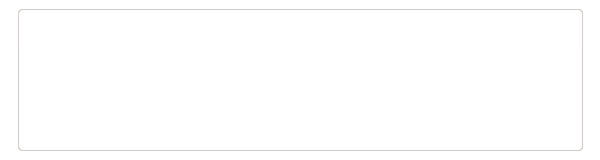
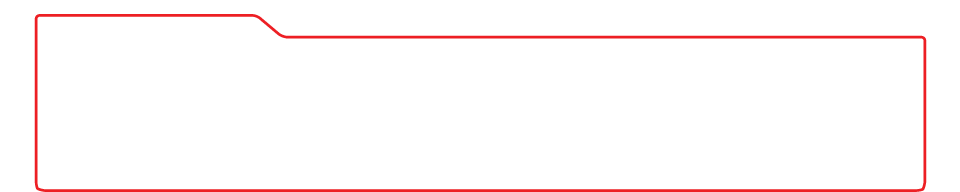
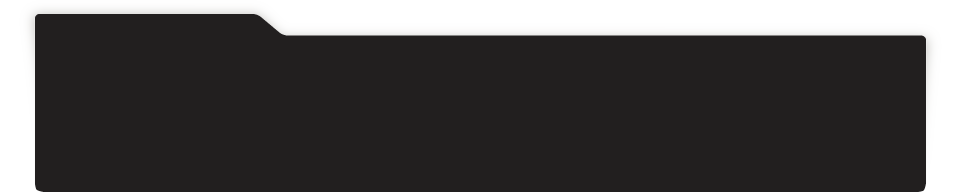
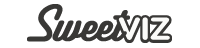
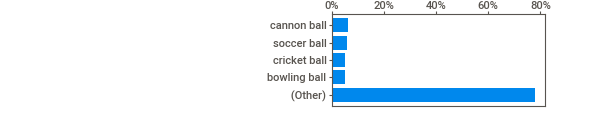
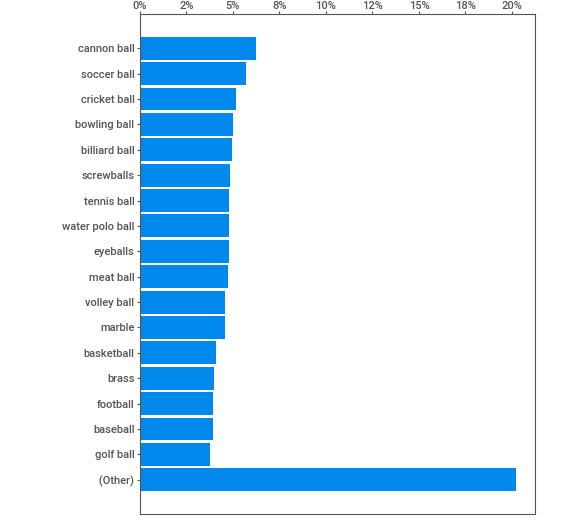
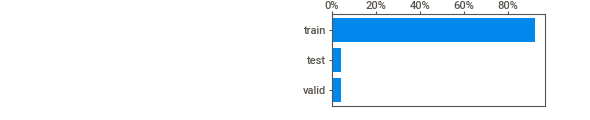
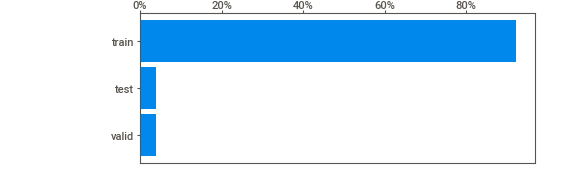
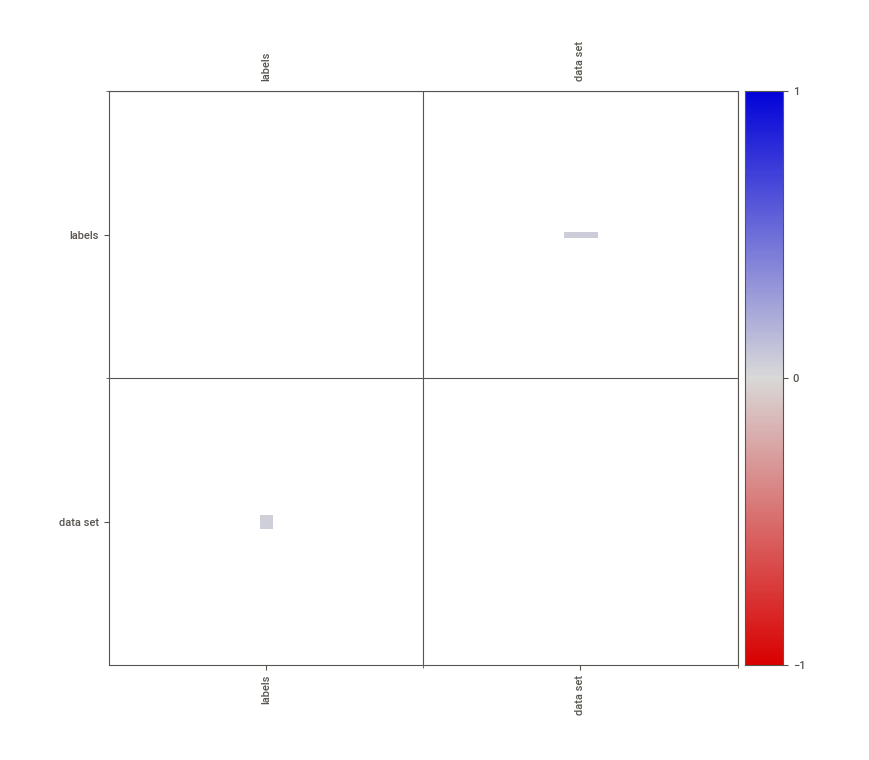
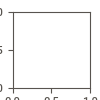

In [16]:
#Mostrando a analise grafica
report.show_notebook()

# Processamento de imagens e plotagem

In [17]:
# O uso do Path referenciará o caminho do dataset e recolherá, juntamente com as variáveis abaixo, as imagens. 
# As mesmas serão transformadas em array para futuro processamento viável.

p = Path('/content/balls/train')
dirs = p.glob('*')
image_data = []
labels = []
image_paths = []
labels_dict = {'baseball':0, 'basketball':1,'beachballs':2,'billiard ball':3,'bowling ball':4,'brass':5,
               'buckeyballs':6,'soccer ball':7,'cricket ball':8,'eyeballs':9,'screwballs':10,'tennis ball':11,'cannon ball':12,
               'water polo ball':13,'meat ball':14,'volley ball':15,'marble':16,'football':17, 'puffballs':18,'golf ball':19,'wiffle ball':20,  
               'medicine ball':21,'wrecking ball':22,'paint balls':23}


for fold in dirs:
  label =str(fold).split('/')[-1]
  cnt = 0
  print(fold)
  for img_path in fold.glob("*.jpg"):
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)
    image_data.append(img_array)
    labels.append(labels_dict[label])
    cnt +=1
  print(cnt)

/content/balls/train/eyeballs
139
/content/balls/train/meat ball
137
/content/balls/train/football
112
/content/balls/train/wrecking ball
69
/content/balls/train/buckeyballs
82
/content/balls/train/billiard ball
143
/content/balls/train/marble
131
/content/balls/train/paint balls
32
/content/balls/train/water polo ball
139
/content/balls/train/golf ball
106
/content/balls/train/cricket ball
150
/content/balls/train/brass
113
/content/balls/train/medicine ball
77
/content/balls/train/bowling ball
145
/content/balls/train/volley ball
131
/content/balls/train/baseball
112
/content/balls/train/wiffle ball
99
/content/balls/train/beachballs
92
/content/balls/train/cannon ball
183
/content/balls/train/tennis ball
139
/content/balls/train/soccer ball
167
/content/balls/train/puffballs
106
/content/balls/train/screwballs
140
/content/balls/train/basketball
116


In [18]:
# Gerando arrays das imagens para análise:

X = np.array(image_data)
y = np.array(labels)

In [19]:
#Contando o numero de classes
ball_classes = os.listdir(p)
len(ball_classes)

24

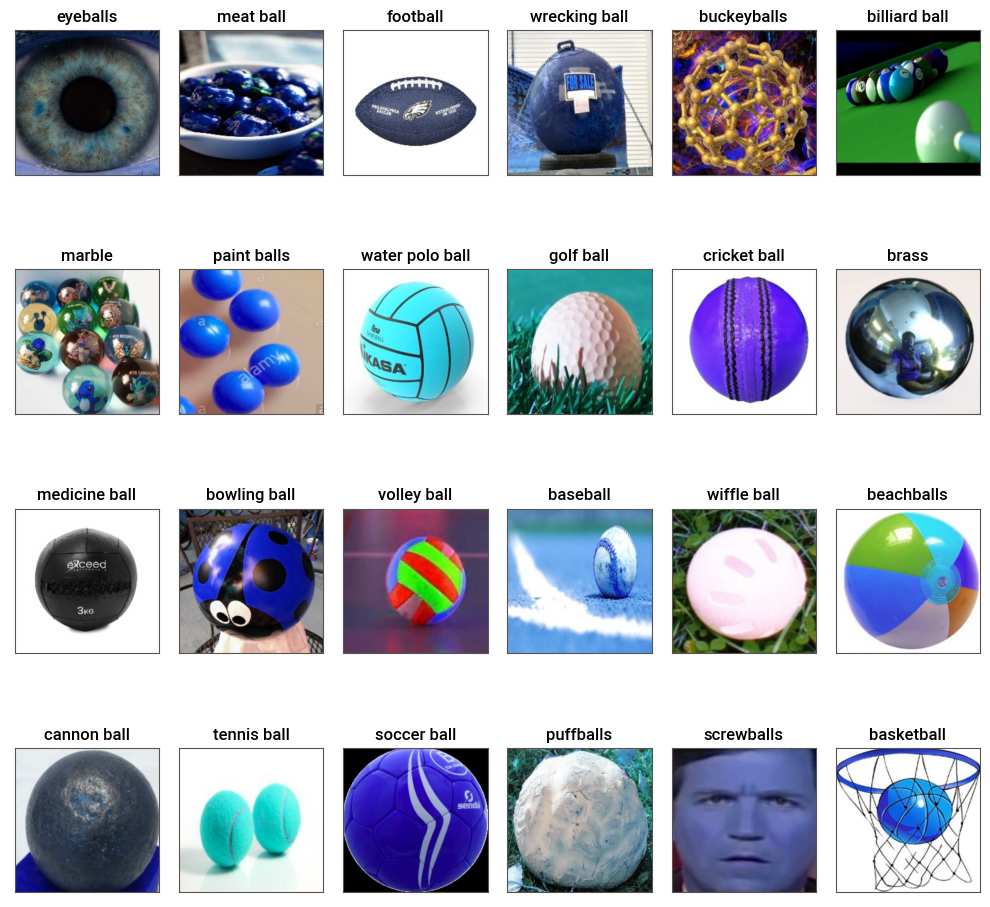

In [20]:
import cv2
#Plotando imagens das 24 classes

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    images = os.listdir(os.path.join(p, ball_classes[i]))
    img = cv2.imread(os.path.join(p, ball_classes[i], images[i]))
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title(ball_classes[i])
fig.tight_layout()    
plt.show()

In [21]:
import shutil

# Excluindo classes que não tenham haver com esportes:
shutil.rmtree('/content/balls/train/brass')
shutil.rmtree('/content/balls/train/screwballs')
shutil.rmtree('/content/balls/train/buckeyballs')
shutil.rmtree('/content/balls/train/eyeballs') 
shutil.rmtree('/content/balls/train/puffballs') 
shutil.rmtree('/content/balls/train/cannon ball') 
shutil.rmtree('/content/balls/train/marble') 
shutil.rmtree('/content/balls/train/medicine ball')
shutil.rmtree('/content/balls/train/wrecking ball')


In [22]:
#repetindo o processo anterior, só que com as imagens remanecentes

p2 = Path('/content/balls/train')
dirs = p2.glob('*')
image_data = []
labels = []
image_paths = []

labels_dict = {'baseball':0, 'basketball':1,'beachballs':2,'billiard ball':3,'bowling ball':4,
               'soccer ball':5,'cricket ball':6,'tennis ball':7,'water polo ball':8,
               'meat ball':9,'volley ball':10,'football':11,'golf ball':12,'wiffle ball':13,  
               'paint balls':14}


for fold in dirs:
  label =str(fold).split('/')[-1]
  cnt = 0
  print(fold)
  for img_path in fold.glob("*.jpg"):
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)
    image_data.append(img_array)

    labels.append(labels_dict[label])

    cnt +=1
  print(cnt)

/content/balls/train/meat ball
137
/content/balls/train/football
112
/content/balls/train/billiard ball
143
/content/balls/train/paint balls
32
/content/balls/train/water polo ball
139
/content/balls/train/golf ball
106
/content/balls/train/cricket ball
150
/content/balls/train/bowling ball
145
/content/balls/train/volley ball
131
/content/balls/train/baseball
112
/content/balls/train/wiffle ball
99
/content/balls/train/beachballs
92
/content/balls/train/tennis ball
139
/content/balls/train/soccer ball
167
/content/balls/train/basketball
116


In [23]:
# Gerando arrays das imagens para análise:

X = np.array(image_data)
y = np.array(labels)

In [24]:
# Printando a quantidade de dados(imagens)

print(len(image_data))
print(len(labels_dict))

1820
15


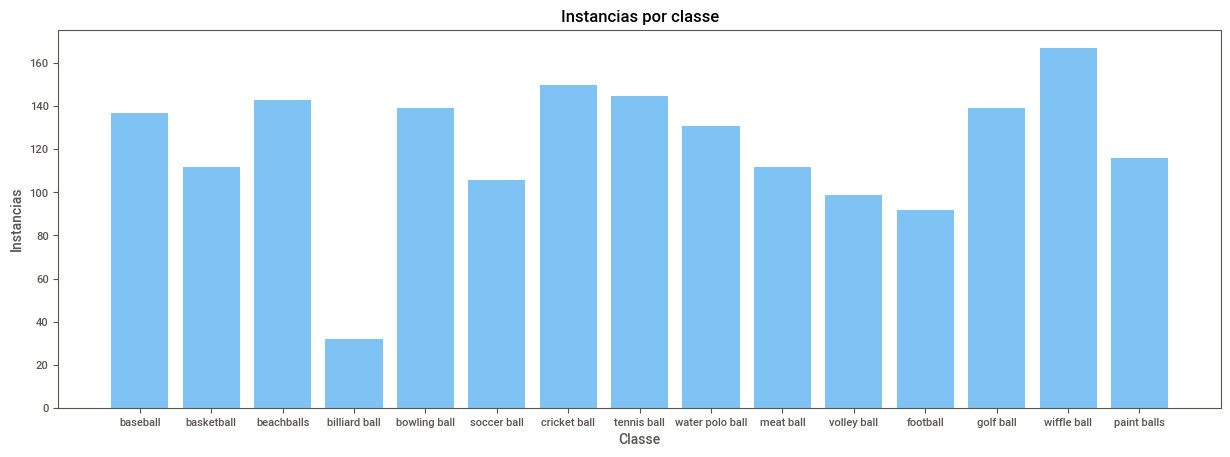

In [25]:
# Gráfico de instancias por classe

plt.figure(figsize=(15,5))

plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Instancias por classe')
bars = ('baseball', 'basketball','beachballs','billiard ball','bowling ball',
               'soccer ball','cricket ball','tennis ball','water polo ball',
               'meat ball','volley ball','football','golf ball','wiffle ball',  
               'paint balls')

x_pos = np.arange(len(bars))
plt.bar(x_pos, Counter(y).values(), align='center', alpha=0.5)
plt.xticks(x_pos, bars)
plt.show()

In [26]:
# Realizando a separação em treino/teste

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [27]:
# Realizando a normalização das imagens ao dividi-las por 255, além de considerá-las como tipo float a fim de aderir mínimas numerações do array:
# Isso tornará mais fluído o treinamento.

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [28]:
#Printando o shape de x treino e x teste
print(X_train.shape[0], 'Dados - Treino')
print(X_test.shape[0], 'Dados - Teste')

1456 Dados - Treino
364 Dados - Teste


In [29]:
# Identificando o número de classes

classes = len(Counter(y_test))
classes

15

In [30]:
# Mudando para to_categorical, para reconhecer os dados:

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

# Rede

In [31]:
# Utilizando um redutor de taxa de aprendizado para adapatar o treinamento:
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.02, min_delta=0.001, patience=3, mode='auto', verbose=1)

In [32]:
# Definindo o modelo CNN:

def get_model(nb_classes = 15, input_shape = (64,64,3)):
  clear_session()
  
  # Iniciando o modelo de rede neural CNN
  model = Sequential()
  model.add(kl.Input(input_shape))

  model.add(kl.Conv2D(128, (3,3),activation=LeakyReLU(alpha=0.2), padding = 'same')) 
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.3))

  model.add(kl.Conv2D(64, (3,3),activation= LeakyReLU(alpha=0.2), padding = 'same')) 
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.3))

  model.add(kl.Conv2D(64, (2,2), activation= LeakyReLU(alpha=0.2),  padding='same')) 
  model.add(kl.MaxPooling2D(pool_size=(2, 2)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Conv2D(32, (1,1), activation= LeakyReLU(alpha=0.2),  padding='same')) 
  model.add(kl.MaxPooling2D(pool_size=(1, 1)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Flatten())
  model.add(kl.Dense(300, activation= LeakyReLU(alpha=0.2)))
  model.add(kl.Dense(150, activation= LeakyReLU(alpha=0.2)))
  model.add(kl.Dropout(0.4)) 
  model.add(kl.Dense(nb_classes, activation='softmax'))

  # Apresentando a estrutura do modelo
  model.summary()

  # Compilando o modelo
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

  # Retornando o modelo
  return model

In [33]:
#mostrando o modelo 
model = get_model(classes, X_test.shape[1:])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

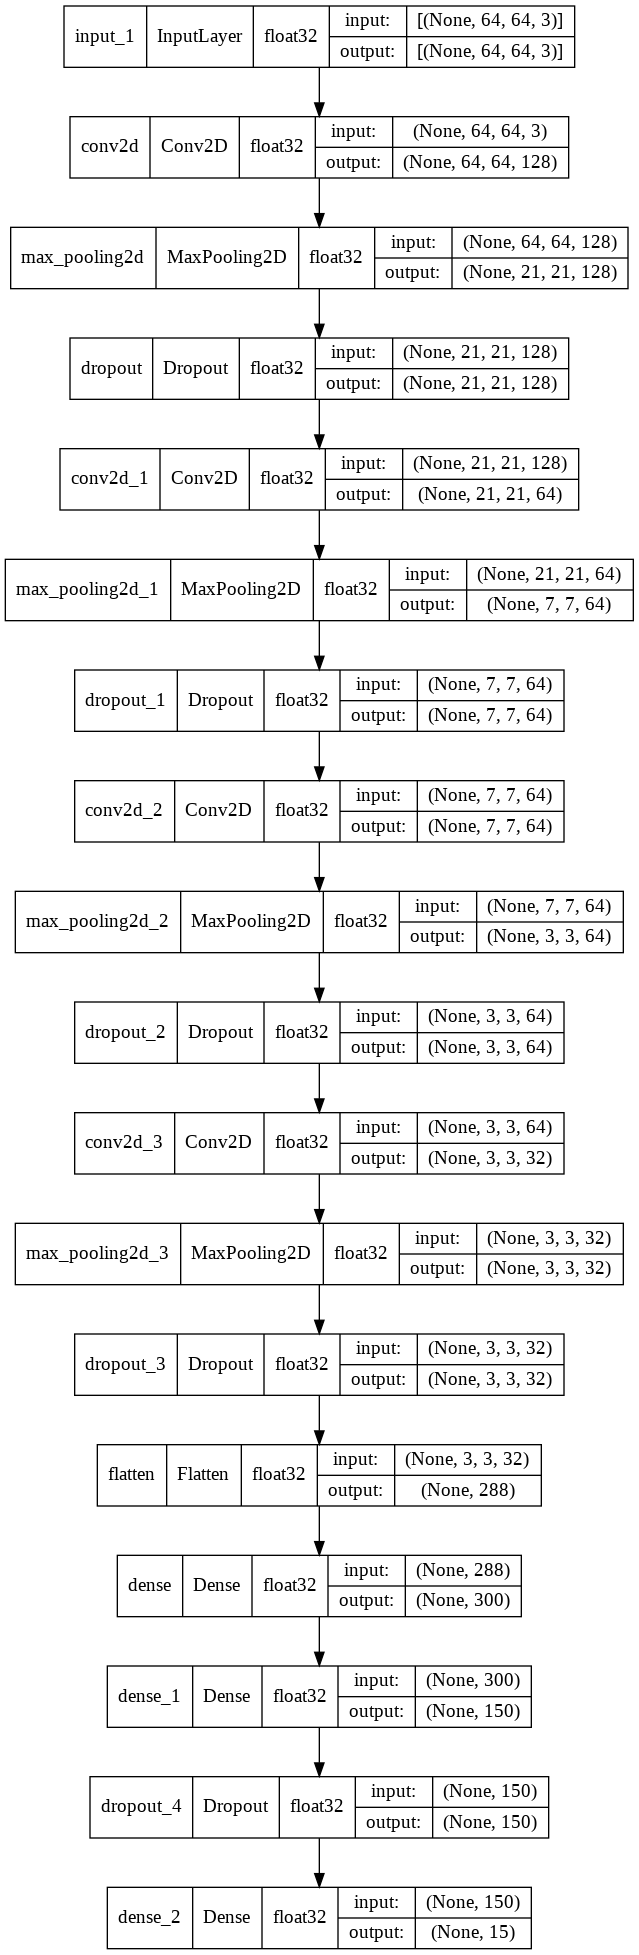

In [34]:
 plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [35]:
# Armazenando o tempo de execução:
start = timeit.default_timer()

# Treinando o modelo
history = model.fit(X_train, y_train,epochs=15,batch_size = 100,validation_split=0.3,verbose=1,callbacks=[lr])
              
# Computando o tempo para treinar (fim)
stop = timeit.default_timer()

# Apresentando o tempo de treinamento
print('Tempo: ', stop - start)  

Epoch 1/15
11/11 [==============================] - 16s 1s/step - loss: 2.6961 - accuracy: 0.0815 - val_loss: 2.6908 - val_accuracy: 0.0801 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - 15s 1s/step - loss: 2.6604 - accuracy: 0.1109 - val_loss: 2.6252 - val_accuracy: 0.1327 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - 15s 1s/step - loss: 2.5470 - accuracy: 0.1766 - val_loss: 2.4489 - val_accuracy: 0.1602 - lr: 0.0010
Epoch 4/15
11/11 [==============================] - 15s 1s/step - loss: 2.3967 - accuracy: 0.2149 - val_loss: 2.3337 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 5/15
11/11 [==============================] - 15s 1s/step - loss: 2.2563 - accuracy: 0.2807 - val_loss: 2.0238 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 6/15
11/11 [==============================] - 15s 1s/step - loss: 2.1105 - accuracy: 0.3199 - val_loss: 1.9330 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 7/15
11/11 [==============================] - 15s 1s/step - loss: 1.9255 - a

In [36]:
 #Contando o numero do loss 
len(history.history['loss'])

15

In [37]:
# Scores

scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

12/12 [==============================] - 1s 115ms/step - loss: 1.2542 - accuracy: 0.6154
[1.2542002201080322, 0.6153846383094788]


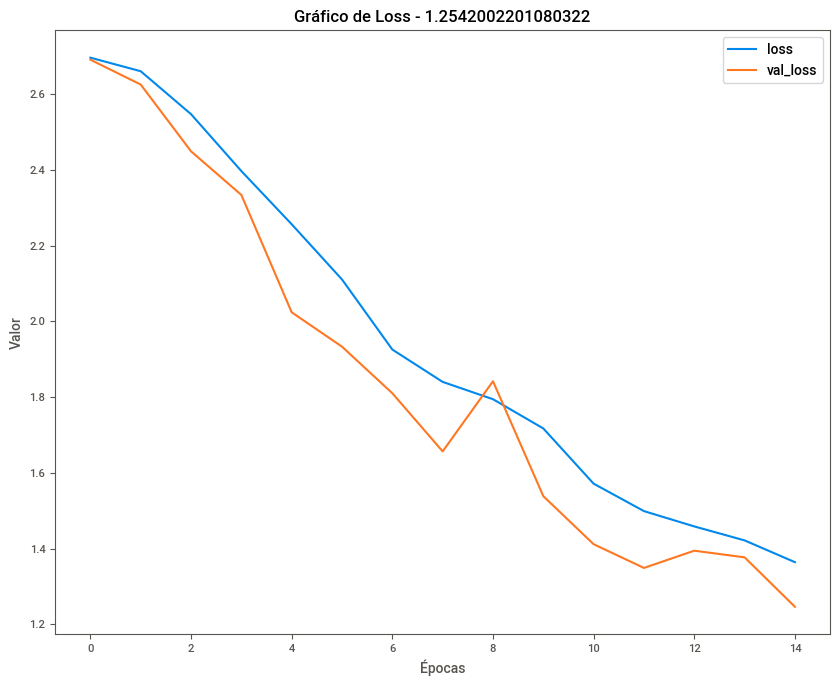

In [38]:
# Gráfico de loss

plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Loss - {scores[0]}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()


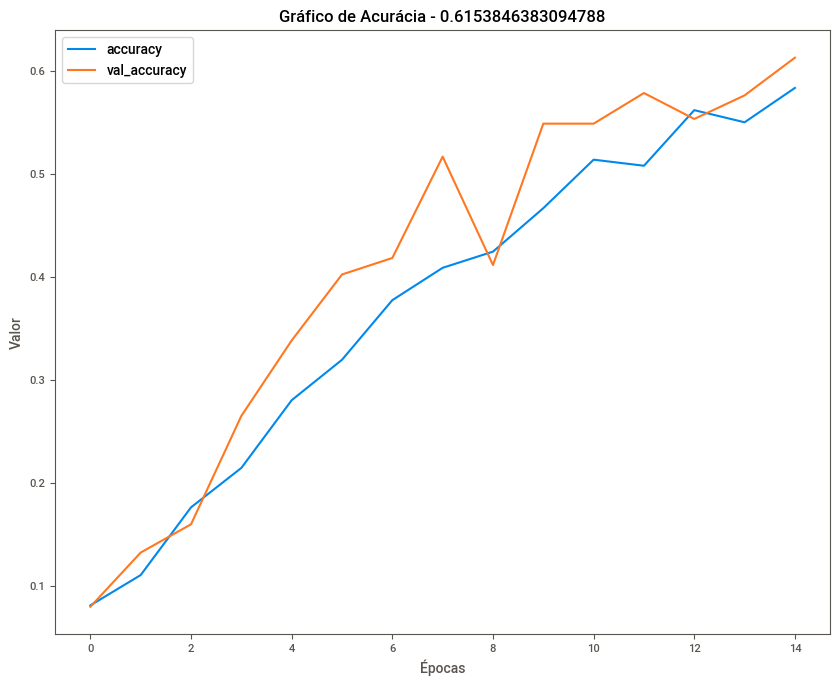

In [39]:
# Gráfico de acurácia

plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Acurácia - {scores[1]}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [40]:
# Armazenando o resultado do treino junntamente com o predict, para realizar a predição

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_test = np.argmax(y_test, axis = 1)
#print(y_test)
#imprimindo a matriz de confusão

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.46      0.54        24
           1       0.67      0.44      0.53        18
           2       0.93      0.72      0.81        18
           3       0.44      0.43      0.44        28
           4       0.37      0.45      0.41        29
           5       0.57      0.75      0.65        32
           6       0.82      0.86      0.84        36
           7       0.56      0.78      0.65        23
           8       0.69      0.87      0.77        31
           9       0.63      0.89      0.74        27
          10       0.67      0.23      0.34        26
          11       0.70      0.64      0.67        22
          12       0.72      0.50      0.59        26
          13       0.43      0.48      0.45        21
          14       0.00      0.00      0.00         3

    accuracy                           0.62       364
   macro avg       0.59      0.57      0.56       364
weighted avg       0.62   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Data augmentation

In [41]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [42]:
N = 20

def ball_aug(ball, N):
  for imagem in ball.glob('*'): 
    img = load_img(imagem)  
    x = img_to_array(img)  
    x = x.reshape((1,) + x.shape)  

# o comando .flow() abaixo gera batches randomicos de imagens transformadas
# e salva o resultado como `preview/` no diretorio 
  i = 0
  for batch in datagen.flow(x, batch_size=1,save_to_dir=ball, save_prefix='daug', save_format='jpg'):
      i += 1
      if i > N:
          break  

In [43]:
baseball = Path('/content/balls/train/baseball')                 
basket = Path('/content/balls/train/basketball')
golf = Path('/content/balls/train/golf ball')
foot = Path('/content/balls/train/football')
wiffle = Path('/content/balls/train/wiffle ball')
meat = Path('/content/balls/train/meat ball')
soccer = Path('/content/balls/train/soccer ball')
beach = Path('/content/balls/train/beachballs')
billiard = Path('/content/balls/train/billiard ball')
tennis = Path('/content/balls/train/tennis ball')
water = Path('/content/balls/train/water polo ball')
paint = Path('/content/balls/train/paint balls')
bowling = Path('/content/balls/train/bowling ball')
cricket = Path('/content/balls/train/cricket ball')
volley = Path('/content/balls/train/volley ball')


ball_aug(baseball, 187)
ball_aug(basket,184)
ball_aug(golf ,194)
ball_aug(foot, 188)
ball_aug(wiffle,201)
ball_aug(meat,163)         
ball_aug(soccer,133)         
ball_aug(beach,208)
ball_aug(billiard,157)         
ball_aug(tennis,161)
ball_aug(water,161)
ball_aug(paint ,268)
ball_aug(bowling,155)   
ball_aug(cricket,149)  
ball_aug(volley,168)

In [44]:

p2 = Path('/content/balls/train')
dirs = p2.glob('*')
image_data = []
labels = []
image_paths = []

labels_dict = {'baseball':0, 'basketball':1,'beachballs':2,'billiard ball':3,'bowling ball':4,
               'soccer ball':5,'cricket ball':6,'tennis ball':7,'water polo ball':8,
               'meat ball':9,'volley ball':10,'football':11,'golf ball':12,'wiffle ball':13,  
               'paint balls':14}


for fold in dirs:
  label =str(fold).split('/')[-1]
  cnt = 0
  print(fold)
  for img_path in fold.glob("*.jpg"):
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)
    image_data.append(img_array)

    labels.append(labels_dict[label])

    cnt +=1
  print(cnt)


/content/balls/train/meat ball
301
/content/balls/train/football
298
/content/balls/train/billiard ball
300
/content/balls/train/paint balls
299
/content/balls/train/water polo ball
300
/content/balls/train/golf ball
299
/content/balls/train/cricket ball
299
/content/balls/train/bowling ball
297
/content/balls/train/volley ball
298
/content/balls/train/baseball
300
/content/balls/train/wiffle ball
300
/content/balls/train/beachballs
300
/content/balls/train/tennis ball
301
/content/balls/train/soccer ball
301
/content/balls/train/basketball
299


# Preparação dos dados

In [45]:
# Gerando arrays das imagens para análise:

X = np.array(image_data)
y = np.array(labels)

In [46]:
# Realizando a separação em treino/teste

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [47]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [48]:
print(X_train.shape[0], 'Dados - Treino')
print(X_test.shape[0], 'Dados - Teste')

3593 Dados - Treino
899 Dados - Teste


In [49]:
# Mudando para to_categorical, para reconhecer os dados:

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

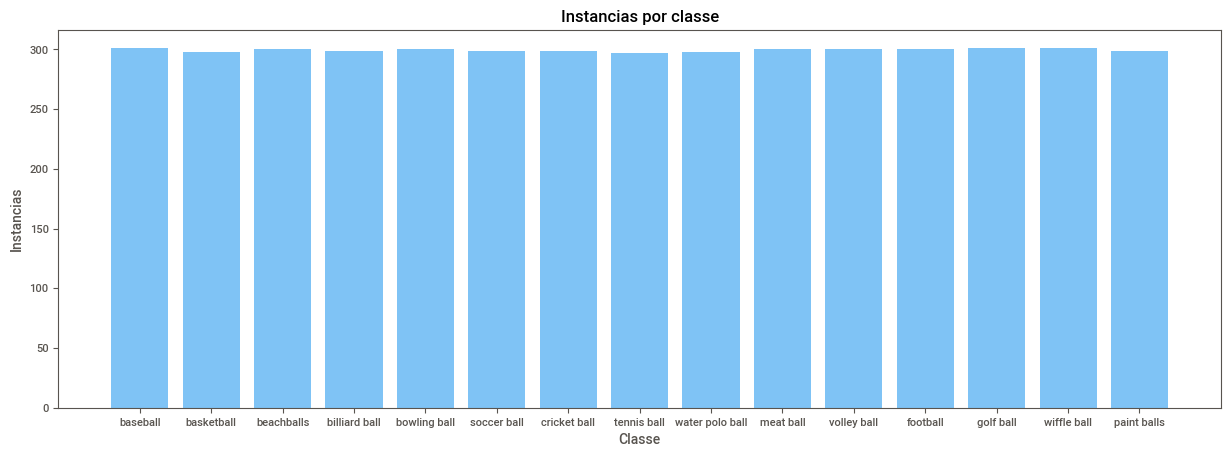

In [50]:
# Gráfico

plt.figure(figsize=(15,5))

plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Instancias por classe')
bars = ('baseball', 'basketball','beachballs','billiard ball','bowling ball',
               'soccer ball','cricket ball','tennis ball','water polo ball',
               'meat ball','volley ball','football','golf ball','wiffle ball',  
               'paint balls')

x_pos = np.arange(len(bars))
plt.bar(x_pos, Counter(y).values(), align='center', alpha=0.5)
plt.xticks(x_pos, bars)
plt.show()

# Rede com Augmentation

In [51]:
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.02, min_delta=0.001, patience=3, mode='auto', verbose=1)

In [52]:
# Definindo o modelo CNN:

def get_model(nb_classes = 15, input_shape = (64,64,3)):
  clear_session()
  
  # Iniciando o modelo de rede neural CNN
  model = Sequential()
  model.add(kl.Input(input_shape))

  model.add(kl.Conv2D(128, (3,3),activation=LeakyReLU(alpha=0.2), padding = 'same')) 
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.3))

  model.add(kl.Conv2D(64, (3,3),activation= LeakyReLU(alpha=0.2), padding = 'same')) 
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.3))

  model.add(kl.Conv2D(64, (2,2), activation= LeakyReLU(alpha=0.2),  padding='same')) 
  model.add(kl.MaxPooling2D(pool_size=(2, 2)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Conv2D(32, (1,1), activation= LeakyReLU(alpha=0.2),  padding='same')) 
  model.add(kl.MaxPooling2D(pool_size=(1, 1)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Flatten())
  model.add(kl.Dense(300, activation= LeakyReLU(alpha=0.2)))
  model.add(kl.Dense(150, activation= LeakyReLU(alpha=0.2)))
  model.add(kl.Dropout(0.4)) 
  model.add(kl.Dense(nb_classes, activation='softmax'))

  # Apresentando a estrutura do modelo
  model.summary()

  # Compilando o modelo
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

  # Retornando o modelo
  return model

In [53]:
#Mostrando o modelo
model = get_model(classes, X_test.shape[1:])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

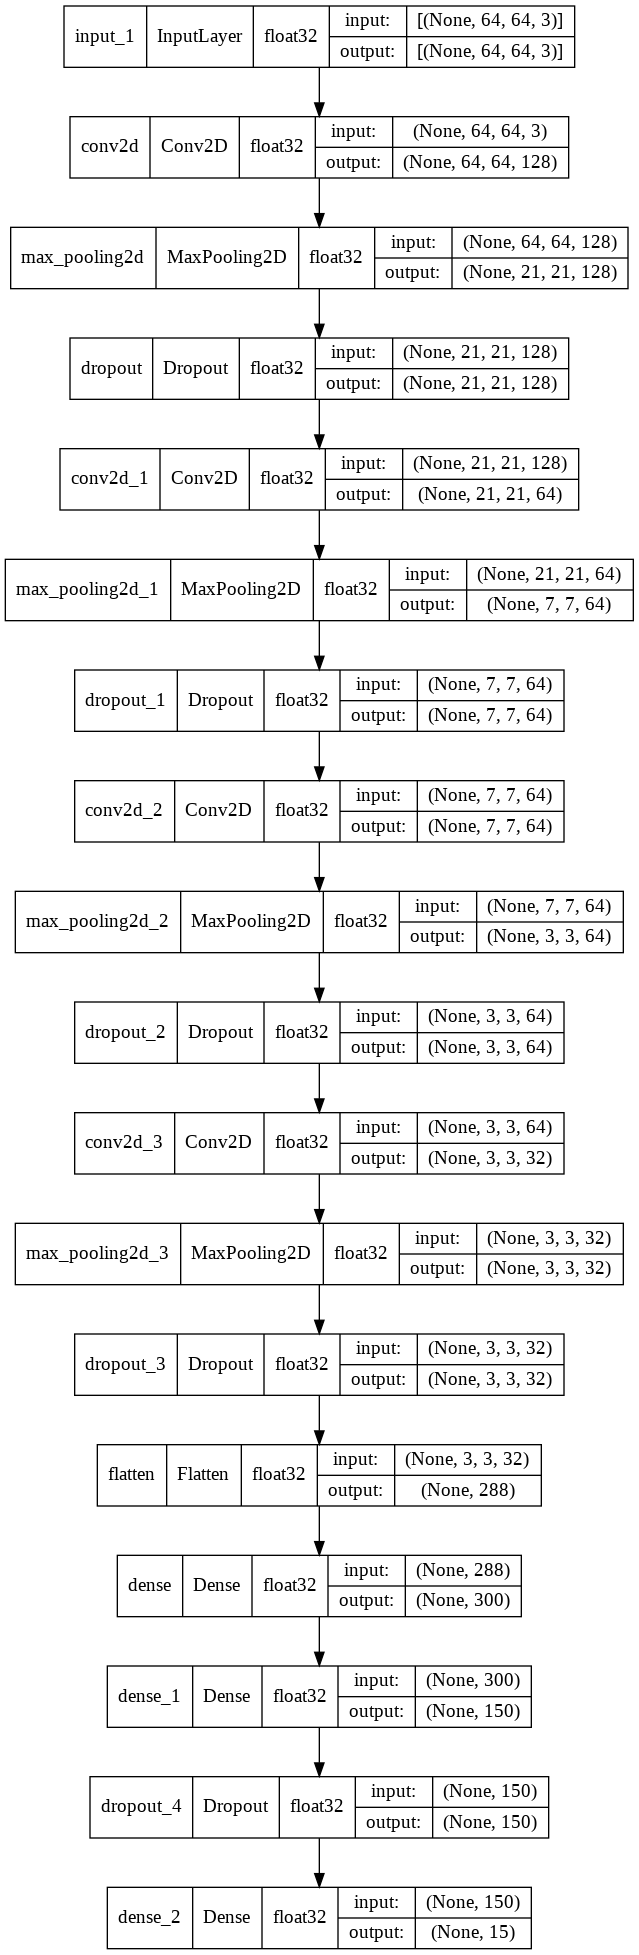

In [54]:
 plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [55]:
# Armazenando o tempo de execução:
start = timeit.default_timer()

# Treinando o modelo
history = model.fit(X_train, y_train,epochs=20,batch_size = 50,validation_split=0.3,verbose=1,callbacks=[lr])
              
# Computando o tempo para treinar (fim)
stop = timeit.default_timer()

# Apresentando o tempo de treinamento
print('Tempo: ', stop - start)  

Epoch 1/20
51/51 [==============================] - 37s 710ms/step - loss: 2.4580 - accuracy: 0.1746 - val_loss: 2.0522 - val_accuracy: 0.4573 - lr: 0.0010
Epoch 2/20
51/51 [==============================] - 36s 702ms/step - loss: 1.7196 - accuracy: 0.4807 - val_loss: 1.2981 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 3/20
51/51 [==============================] - 36s 699ms/step - loss: 1.2250 - accuracy: 0.6577 - val_loss: 1.0615 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 4/20
51/51 [==============================] - 36s 701ms/step - loss: 0.9567 - accuracy: 0.7364 - val_loss: 0.8365 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 5/20
51/51 [==============================] - 36s 700ms/step - loss: 0.8586 - accuracy: 0.7698 - val_loss: 0.9190 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 6/20
51/51 [==============================] - 35s 697ms/step - loss: 0.8078 - accuracy: 0.7797 - val_loss: 0.6802 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 7/20
51/51 [==============================] - 36s 698ms/st

In [56]:
  #Contando o loss
  len(history.history['loss'])

20

In [57]:
# Scores

scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

29/29 [==============================] - 3s 114ms/step - loss: 0.4867 - accuracy: 0.8587
[0.4867158532142639, 0.8587319254875183]


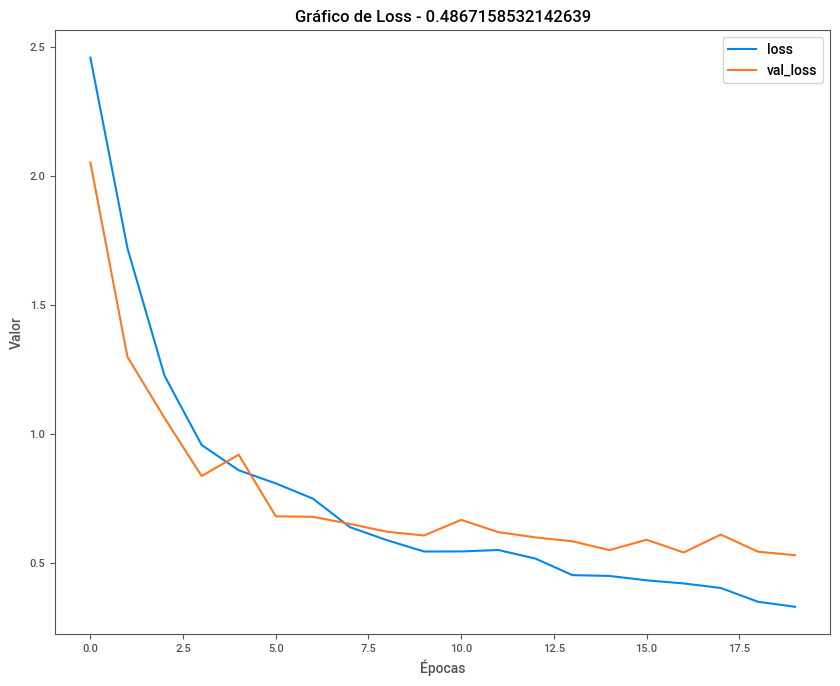

In [58]:
# Gráfico de loss

plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Loss - {scores[0]}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()


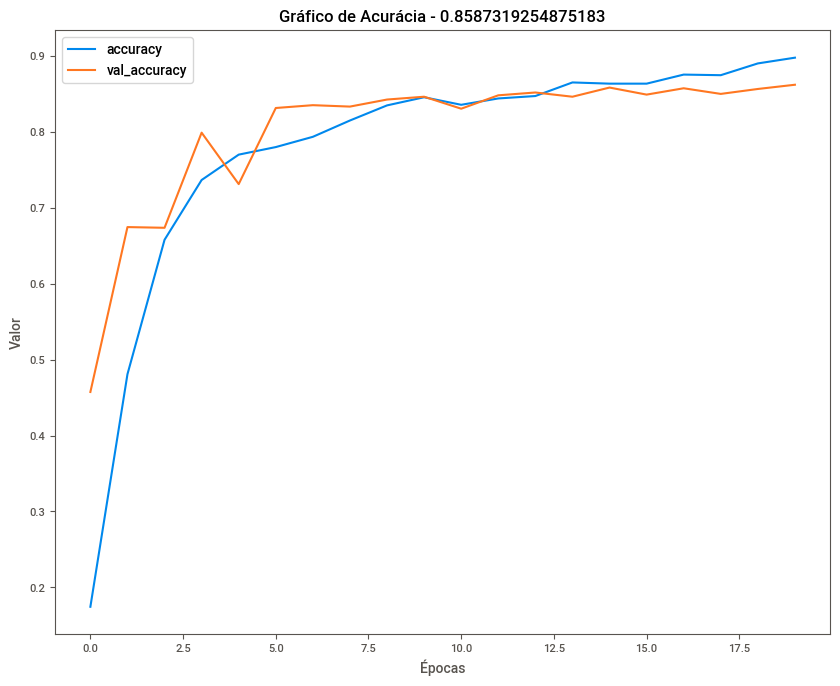

In [59]:
# Gráfico de acurácia

plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Acurácia - {scores[1]}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [60]:
# Armazenando o resultado do treino junntamente com o predict, para realizar a predição

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_test = np.argmax(y_test, axis = 1)
#print(y_test)
#imprimindo a matriz de confusão

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83        54
           1       0.88      0.83      0.86        72
           2       0.90      0.93      0.92        59
           3       0.85      0.81      0.83        58
           4       0.71      0.80      0.76        56
           5       0.88      0.84      0.85        67
           6       0.89      0.91      0.90        65
           7       0.87      0.90      0.89        60
           8       0.90      0.85      0.88        54
           9       0.88      0.96      0.92        53
          10       0.91      0.88      0.89        57
          11       0.90      0.95      0.92        63
          12       0.78      0.73      0.75        52
          13       0.77      0.75      0.76        67
          14       0.93      0.90      0.92        62

    accuracy                           0.86       899
   macro avg       0.86      0.86      0.86       899
weighted avg       0.86   

# Salvando modelo e resultados

In [61]:
#Salvando o modelo
model.save('modelo')

INFO:tensorflow:Assets written to: modelo/assets


INFO:tensorflow:Assets written to: modelo/assets


In [62]:
#  pode ser usado para reconstruir o modelo de forma idêntica.
reconstructed_model = keras.models.load_model("modelo")

In [63]:
#Salvando um csv do loss

np.savetxt("loss.csv", history.history['loss'], delimiter=",")

In [64]:
import pickle

pickle_out=open("modelo_treinado",'wb')
pickle.dump(model,pickle_out)
pickle_out.close()

INFO:tensorflow:Assets written to: ram://3d27a808-d56d-4854-acf0-2f8efb2df022/assets


INFO:tensorflow:Assets written to: ram://3d27a808-d56d-4854-acf0-2f8efb2df022/assets
